In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("online_retail.csv")
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
# Check for missing values
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
# Drop rows with missing CustomerID and Description
df = df.dropna(subset=['CustomerID', 'Description'])

# Confirm missing values are removed
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [5]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with negative Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove duplicate rows
df = df.drop_duplicates()

# Check the dataset after preprocessing
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [6]:
# Create TotalSpend feature
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Find the most recent date in the dataset
recent_date = df['InvoiceDate'].max()

# Calculate Recency (days since last purchase for each transaction)
df['Recency'] = (recent_date - df['InvoiceDate']).dt.days

# Group by CustomerID to calculate Frequency and Monetary
customer_data = df.groupby('CustomerID').agg(
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalSpend', 'sum'),
    Recency=('Recency', 'min')  # Recency is based on the most recent transaction
).reset_index()

# Check the new features
print(customer_data.head())

   CustomerID  Frequency  Monetary  Recency
0     12346.0          1  77183.60      325
1     12347.0          7   4310.00        1
2     12348.0          4   1797.24       74
3     12349.0          1   1757.55       18
4     12350.0          1    334.40      309


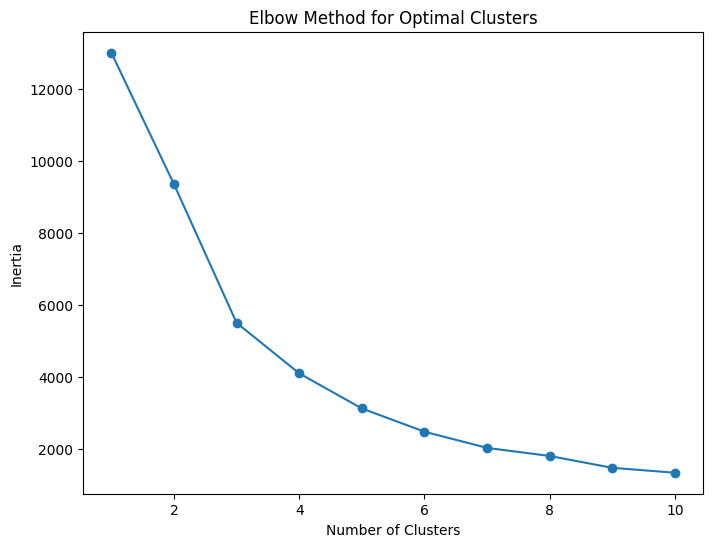

   CustomerID  Frequency  Monetary  Recency  Cluster
0     12346.0          1  77183.60      325        3
1     12347.0          7   4310.00        1        0
2     12348.0          4   1797.24       74        0
3     12349.0          1   1757.55       18        0
4     12350.0          1    334.40      309        1


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Normalize the features (Frequency, Monetary, Recency)
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Frequency', 'Monetary', 'Recency']])

# Elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the plot, choose the optimal number of clusters (let's assume it's 4 for this example)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Check the resulting clusters
print(customer_data.head())

In [8]:
# Group by the cluster and calculate the mean values of Frequency, Monetary, and Recency for each cluster
cluster_summary = customer_data.groupby('Cluster')[['Frequency', 'Monetary', 'Recency']].mean()

# Display the summary
print(cluster_summary)

         Frequency       Monetary     Recency
Cluster                                      
0         3.682711    1353.625312   42.702685
1         1.552015     478.848773  247.075914
2        82.538462  127187.959231    6.384615
3        22.333333   12690.500392   14.500000


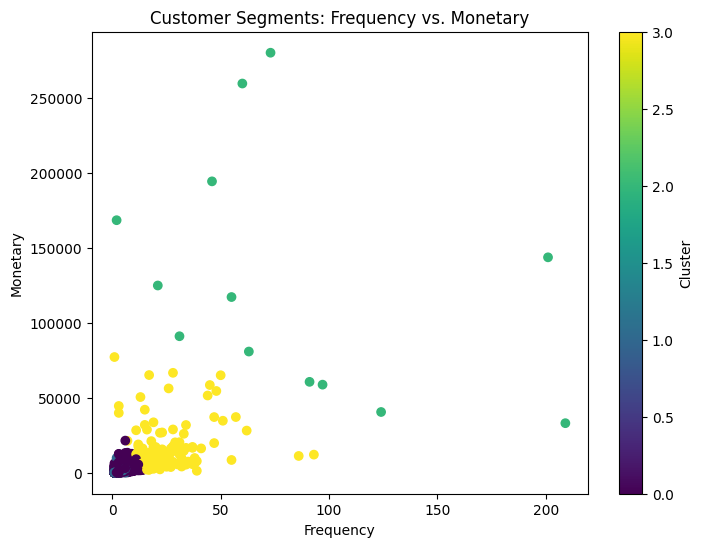

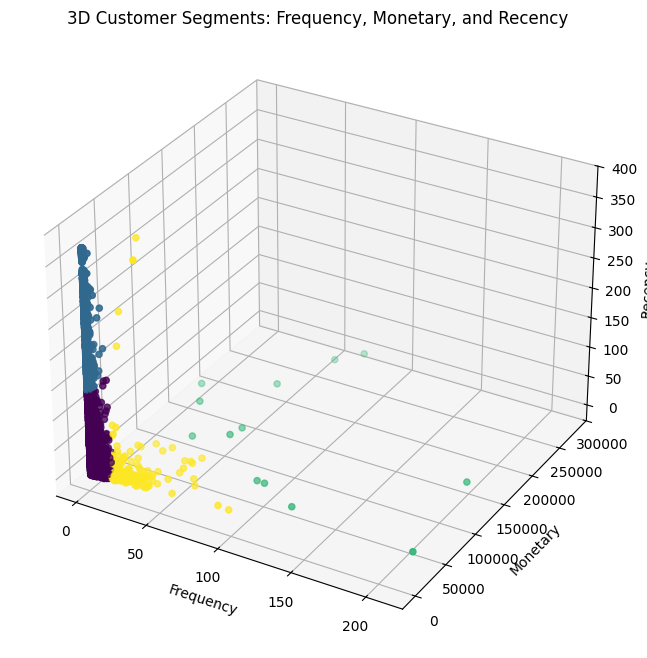

In [9]:
# Scatter plot for Frequency vs. Monetary colored by Cluster
plt.figure(figsize=(8, 6))
plt.scatter(customer_data['Frequency'], customer_data['Monetary'], c=customer_data['Cluster'], cmap='viridis')
plt.title('Customer Segments: Frequency vs. Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster')
plt.show()

# Optional: 3D scatter plot for Frequency, Monetary, and Recency
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_data['Frequency'], customer_data['Monetary'], customer_data['Recency'], c=customer_data['Cluster'], cmap='viridis')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')
plt.title('3D Customer Segments: Frequency, Monetary, and Recency')
plt.show()

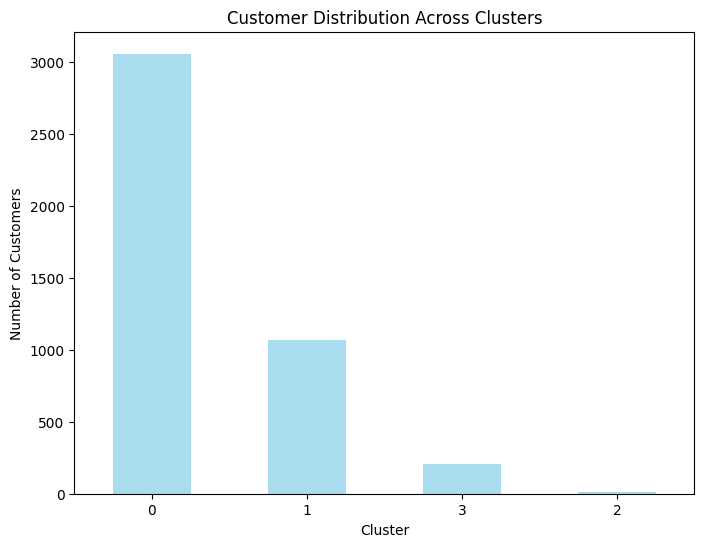

In [16]:
# Count the number of customers in each cluster
cluster_counts = customer_data['Cluster'].value_counts()

# Plot the distribution of clusters
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Customer Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()


In [17]:
# Calculate the mean of Frequency, Monetary, and Recency for each cluster
cluster_summary = customer_data.groupby('Cluster')[['Frequency', 'Monetary', 'Recency']].mean()
print(cluster_summary)


         Frequency       Monetary     Recency
Cluster                                      
0         3.682711    1353.625312   42.702685
1         1.552015     478.848773  247.075914
2        82.538462  127187.959231    6.384615
3        22.333333   12690.500392   14.500000


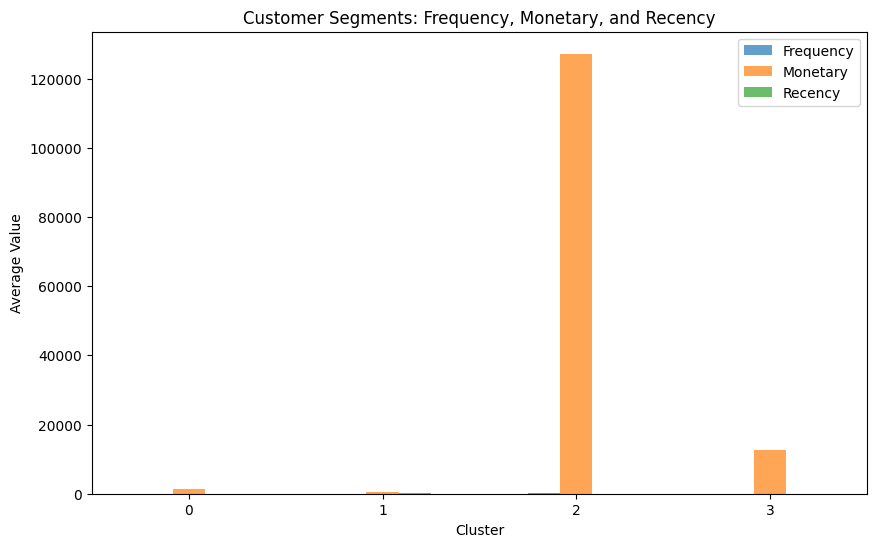

In [18]:
# Plotting the average values of Frequency, Monetary, and Recency for each cluster
cluster_summary.plot(kind='bar', figsize=(10, 6), alpha=0.7)
plt.title('Customer Segments: Frequency, Monetary, and Recency')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.show()


**Step 1: Overview of Clusters**

The customers were segmented into distinct clusters based on their purchase behaviors: Frequency (how often they shop), Monetary (how much they spend), and Recency (how recently they made a purchase). The clustering model revealed four unique customer groups with different behaviors.

**Step 2: Cluster Characteristics**

The clusters can be summarized as follows:

Cluster 0: Regular but Low-Spending Customers
These customers have moderate frequency (3.68 purchases), low monetary value ($1,353), and moderate recency (42.7 days since the last purchase). They are likely regular but not high-spending shoppers. To improve their lifetime value, targeted promotions may encourage higher spending.

Cluster 1: Inactive Customers
This group exhibits low frequency (1.55 purchases), very low monetary value ($478), and high recency (247 days since the last purchase). These customers have been inactive for a while and may need re-engagement efforts such as email reminders or special discounts to rekindle their interest.

Cluster 2: High-Value Customers
These customers show very high frequency (82.5 purchases), extremely high monetary value ($127,188), and very recent activity (6.38 days since the last purchase). Cluster 2 represents the most valuable group, consisting of frequent and high-spending customers. They should be rewarded with loyalty programs or exclusive offers to ensure continued engagement.

Cluster 3: Active but Moderate-Spending Customers
These customers have moderate frequency (22.33 purchases), moderate monetary value ($12,690), and low recency (14.5 days). While they are active, they aren't the highest spenders. Personalized recommendations could further increase both their spending and frequency of purchases.

**Step 3: Actionable Insights**

The segmentation reveals several actionable insights for business strategy:

Cluster 0: This group could benefit from targeted promotions aimed at increasing their spending. Engaging them with personalized offers may boost their lifetime value.

Cluster 1: Since these customers have been inactive for an extended period, re-engagement strategies such as email reminders, discounts, or exclusive promotions could help bring them back into the purchasing cycle.

Cluster 2: As the most valuable group, Cluster 2 should be prioritized for loyalty programs, VIP services, and exclusive offers. Retaining these customers is key to driving long-term revenue.

Cluster 3: These customers are still valuable but could be further engaged with personalized recommendations based on their past purchase behavior. By increasing both purchase frequency and spend, Cluster 3 could become a higher-value group over time.  


**Step 4: Conclusion**

The customer segmentation analysis provides valuable insights into customer behavior, enabling businesses to implement targeted marketing strategies. By identifying high-value and inactive customers, businesses can tailor their efforts to boost revenue and improve retention. This approach also supports effective resource allocation and enhances customer relationship management, ensuring a more personalized and efficient customer experience.

